# MICROPROBING 

In [1]:
# # # NOTE -> log likelihood is slightly different for microprobing vs the more general case 
# # # because for microprobing at the momemnt i'm running "beta" and "slope" as a GLM outside MCMC
# # This won't work here - it is copy and pasted from micro_probe.py for reference only
# def ln_likelihood(self, params, response):
#     '''Log likelihood
#     DODGY - ASK REMCO
#     '''
#     # Get the predicted time series
#     pred = self.prfpy_model.return_prediction(
#         mu_x=np.array([params[0]]),
#         mu_y=np.array([params[1]]),
#         size=np.array([self.tiny_prf_size]),
#         beta=np.array([1]), # beta is the amplitude of the response
#         baseline=np.array([0]),
#     )
#     # Estimate slope and offset using calssical GLM and OLS
#     # THIS IS DIFFERENT FROM prf_bayes (where we fit the slope and offset inside MCMC)
#     m_response = np.mean(response)
#     m_pred = np.mean(pred)
#     slope = np.sum((response - m_response) * (pred - m_pred)) / np.sum((pred - m_pred) **2)
#     offset = m_response - slope * m_pred
#     pred = pred * slope + offset

#     # Calculate log likelihood
#     residuals = response - pred        
#     # Estimate mean and std of the residuals (assuming normal distribution)
#     # -> check for nonfinite values 
#     try:        
#         muhat, sigmahat = stats.norm.fit(residuals.squeeze())
#     except:
#         # In case of invalid output
#         return -np.inf # If there are non-finite values, return a small value
    
#     # Check if the spread is valid
#     if sigmahat <= 0:
#         return -np.inf
    
#     # Calculate the log likelihood of the residuals
#     # given the fitted normal distribution (feels a bit circular?)
#     # then add it up for all time points
#     log_like = stats.norm.logpdf(residuals, muhat, sigmahat).sum()

#     return log_like

Before running this notebook - install this package
(i.e., in the terminal, inside this folder run:
"pip install -e .")

You also need: 

* emcee               https://emcee.readthedocs.io/en/stable/user/install/

* prfpy               https://github.com/VU-Cog-Sci/prfpy.git (or https://github.com/spinoza-centre/prfpy_csenf.git if you want the contrast sensitivity function.)

* dag_prf_utils       https://github.com/mdaghlian/dag_prf_utils.git


Also a bit of an apology... There is some inconsistency in naming between prfpy and dag_prf_utils. I promise there is a good reason for this. I want prfpy to be backwards compatible. But, some names interfere with each other, when you start including other models (e.g., size, compared to size_1, and size_2 in the DN model). Here is the mapping for the gaussian model:

```
prfpy       dag_prf_utils

mu_x        x
mu_y        y
size        size_1
beta        amp_1
baseline    bold_baseline
hrf_1       hrf_deriv
hrf_2       hrf_disp


```

Most of the time you shouldn't have to think about it...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


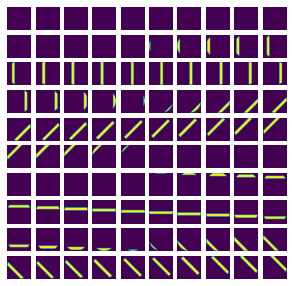

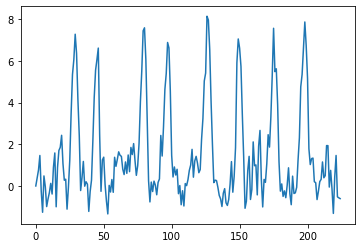

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
try:
    from prfpy.stimulus import PRFStimulus2D
    from prfpy.model import Iso2DGaussianModel
except:
    from prfpy_csenf.stimulus import PRFStimulus2D
    from prfpy_csenf.model import Iso2DGaussianModel
import os
import yaml
import pickle
from datetime import datetime

# If you already have the design matrix as a numpy array, you can simply load it...
dm = np.load('./design_matrix.npy')

# You can see we have a binarized matrix, of a bar moving across the screen...
fig = plt.figure()
rows = 10
cols = 10
fig.set_size_inches(5,5)
for i in range(100):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(dm[:,:,i], vmin=0, vmax=1)
    ax.axis('off')
# Now we need to enter the design matrix in a way that prfpy can read it. 
# If for some reason you do not have the original dimensions, but you do have the dov, you can use this calculator:
# https://elvers.us/perception/visualAngle/ to make up some values for screen_size and distance, which will work...
prf_stim = PRFStimulus2D(
    screen_size_cm=39.3,          # Distance of screen to eye
    screen_distance_cm=196,  # height of the screen (i.e., the diameter of the stimulated region)
    design_matrix=dm,                                   # dm (npix x npix x time_points)
    TR=1.5,                                  # TR
    )
# Now we can make the model
model = 'gauss'
# HRF is determined by coefficients for the canonical HRF, its time derivative, and its dispersion derivative
# Here we set it at 1, 4.6 and 0 (what we have found to work at spinoza)
prfpy_model = Iso2DGaussianModel(stimulus=prf_stim, hrf=[1, 4.6, 0]) 


# Load the runs

psc_runs = np.load('eg_data.npy')
# Show an example
plt.figure()
plt.plot(psc_runs[0,:])

# Metropolis Hastings - with MCMC 

In [3]:
from prfpy_bayes.micro_probe import MicroProbe
bprf = MicroProbe(
    prfpy_model = prfpy_model,  # prfpy model objects
    real_ts = psc_runs,         # time series (data)
    bounds = [-5,5],            # bounds for x,y
    tiny_prf_size = 0.01,       # tiny prf size     
)

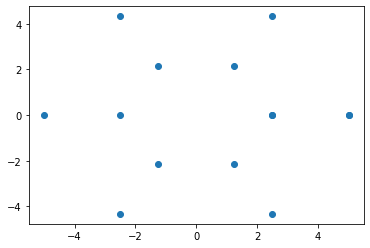

In [4]:
import emcee
# Some starting poisitions... (a bit random - but lets go for it for now)
pol = np.linspace(0, 2*np.pi, 7)
ecc = np.array([2.5, 5]) # , 2,3, 4,])
pol,ecc = np.meshgrid(pol, ecc)
x,y = ecc*np.cos(pol), ecc*np.sin(pol)
x,y = x.flatten(), y.flatten()
plt.scatter(x,y)
walkers = np.array([x,y]).T


In [5]:
# Lets run the fitting for voxel 0
# -> need to specify the "move", i.e., how it makes steps
import emcee 
moves = emcee.moves.GaussianMove(cov=.5, mode='vector') # Setting cov=.1 for a small step size
# From EMCEE documentation
"""A Metropolis step with a Gaussian proposal function.

Args:
    cov: The covariance of the proposal function. This can be a scalar,
        vector, or matrix and the proposal will be assumed isotropic,
        axis-aligned, or general respectively.
    mode (Optional): Select the method used for updating parameters. This
        can be one of ``"vector"``, ``"random"``, or ``"sequential"``. The
        ``"vector"`` mode updates all dimensions simultaneously,
        ``"random"`` randomly selects a dimension and only updates that
        one, and ``"sequential"`` loops over dimensions and updates each
        one in turn.
    factor (Optional[float]): If provided the proposal will be made with a
        standard deviation uniformly selected from the range
        ``exp(U(-log(factor), log(factor))) * cov``. This is invalid for
        the ``"vector"`` mode.

Raises:
    ValueError: If the proposal dimensions are invalid or if any of any of
        the other arguments are inconsistent.

"""

# We also need to include the argument "skip_initial_state_check" in the kwargs_run
# This is because the default "move" in emcee needs a minimum number of walkers 
# but we are using the GaussianMove which does not have this requirement
# n_steps = 500
# bprf.run_mcmc_fit(
#     idx=0,                      # Index of the vertex times series to fit     
#     n_walkers=len(walkers),     # Number of walkers (i.e., starting points)
#     walkers=walkers,            # Starting points
#     n_steps=n_steps,                # How many steps to takes
#     kwargs_sampler={'moves':moves},  # Arguments for the sampler
#     kwargs_run = {'skip_initial_state_check':True, },        
# )

'A Metropolis step with a Gaussian proposal function.\n\nArgs:\n    cov: The covariance of the proposal function. This can be a scalar,\n        vector, or matrix and the proposal will be assumed isotropic,\n        axis-aligned, or general respectively.\n    mode (Optional): Select the method used for updating parameters. This\n        can be one of ``"vector"``, ``"random"``, or ``"sequential"``. The\n        ``"vector"`` mode updates all dimensions simultaneously,\n        ``"random"`` randomly selects a dimension and only updates that\n        one, and ``"sequential"`` loops over dimensions and updates each\n        one in turn.\n    factor (Optional[float]): If provided the proposal will be made with a\n        standard deviation uniformly selected from the range\n        ``exp(U(-log(factor), log(factor))) * cov``. This is invalid for\n        the ``"vector"`` mode.\n\nRaises:\n    ValueError: If the proposal dimensions are invalid or if any of any of\n        the other arguments

### test timing

In [32]:
time_start = datetime.now()
bprf1 = MicroProbe(
    prfpy_model = prfpy_model,  # prfpy model objects
    real_ts = psc_runs,         # time series (data)
    bounds = [-5,5],            # bounds for x,y
    tiny_prf_size = 0.01,       # tiny prf size     
)

time_start = datetime.now()
bprf1.run_mcmc_fit(
    idx=0,                      # Index of the vertex times series to fit     
    n_walkers=len(walkers),     # Number of walkers (i.e., starting points)
    walkers=walkers,            # Starting points
    n_steps=50,                # How many steps to takes
    kwargs_sampler={'moves':moves},  # Arguments for the sampler
    kwargs_run = {'skip_initial_state_check':True, },        
)
t1 = datetime.now()-time_start
print(f'Time taken: {t1}')


Running in serial


/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_bayes/prfpy_bayes/micro_probe.py:71: RuntimeWarning: invalid value encountered in scalar divide
  slope = np.sum((response - m_response) * (pred - m_pred)) / np.sum((pred - m_pred) **2)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_bayes/prfpy_bayes/micro_probe.py:71: RuntimeWarning: invalid value encountered in scalar divide
  slope = np.sum((response - m_response) * (pred - m_pred)) / np.sum((pred - m_pred) **2)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_bayes/prfpy_bayes/micro_probe.py:71: RuntimeWarning: invalid value encountered in scalar divide
  slope = np.sum((response - m_response) * (pred - m_pred)) / np.sum((pred - m_pred) **2)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_bayes/prfpy_bayes/micro_probe.py:71: RuntimeWarning: invalid value encountered in scalar divide
  slope = np.sum((response - m_response) * (pred - m_pred)) / np.sum((pred - m_pred) **2)
/data1/p

prf_params.shape[-1]=8
include hrf = True
include rsq = True
Time taken: 0:00:12.378563


In [58]:
from prfpy_bayes.micro_probe import *
# *************************************************************

time_start = datetime.now()
bprf2 = MicroProbe(
    prfpy_model = prfpy_model,  # prfpy model objects
    real_ts = psc_runs,         # time series (data)
    bounds = [-5,5],            # bounds for x,y
    tiny_prf_size = 0.01,       # tiny prf size     
)
# Same again but wiht multiprocessing
import multiprocessing

time_start = datetime.now()
with multiprocessing.Pool(14) as pool:
    prfpy_global_model.set_model(prfpy_model)
    bprf2.run_mcmc_fit(
        idx=0,                      # Index of the vertex times series to fit     
        n_walkers=len(walkers),     # Number of walkers (i.e., starting points)
        walkers=walkers,            # Starting points
        n_steps=250,                # How many steps to takes
        kwargs_sampler={
            'moves':emcee.moves.DESnookerMove(), 
            },  # Arguments for the sampler
        kwargs_run = {'skip_initial_state_check':True},        
        pool=pool,
    )

t2 = datetime.now()-time_start
print(f"Single process: {t1}")
print(f"Multi process: {t2}")


/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_bayes/prfpy_bayes/micro_probe.py:326: RuntimeWarning: invalid value encountered in scalar divide
  slope = np.sum((response - m_response) * (pred - m_pred)) / np.sum((pred - m_pred) **2)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_bayes/prfpy_bayes/micro_probe.py:326: RuntimeWarning: invalid value encountered in scalar divide
  slope = np.sum((response - m_response) * (pred - m_pred)) / np.sum((pred - m_pred) **2)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_bayes/prfpy_bayes/micro_probe.py:326: RuntimeWarning: invalid value encountered in scalar divide
  slope = np.sum((response - m_response) * (pred - m_pred)) / np.sum((pred - m_pred) **2)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_bayes/prfpy_bayes/micro_probe.py:326: RuntimeWarning: invalid value encountered in scalar divide
  slope = np.sum((response - m_response) * (pred - m_pred)) / np.sum((pred - m_pred) **2)
/dat

Running in parallel


/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_bayes/prfpy_bayes/micro_probe.py:326: RuntimeWarning: invalid value encountered in scalar divide
  slope = np.sum((response - m_response) * (pred - m_pred)) / np.sum((pred - m_pred) **2)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_bayes/prfpy_bayes/micro_probe.py:326: RuntimeWarning: invalid value encountered in scalar divide
  slope = np.sum((response - m_response) * (pred - m_pred)) / np.sum((pred - m_pred) **2)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_bayes/prfpy_bayes/micro_probe.py:326: RuntimeWarning: invalid value encountered in scalar divide
  slope = np.sum((response - m_response) * (pred - m_pred)) / np.sum((pred - m_pred) **2)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_bayes/prfpy_bayes/micro_probe.py:326: RuntimeWarning: invalid value encountered in scalar divide
  slope = np.sum((response - m_response) * (pred - m_pred)) / np.sum((pred - m_pred) **2)
/dat

prf_params.shape[-1]=8
include hrf = True
include rsq = True
Single process: 0:00:12.378563
Multi process: 0:00:26.591819


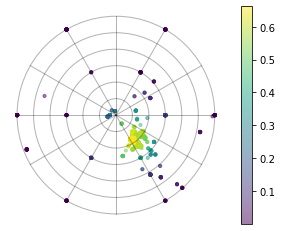

In [59]:
bprf2.sampler[0].visual_field(
    dot_col='rsq', 
    th={}, 
    dot_size=10, 
)

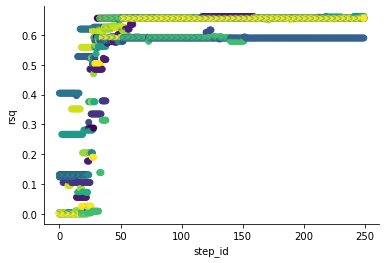

In [60]:
bprf2.sampler[0].scatter(
    'step_id', 'rsq', pc='walker_id', th={},
)

Ok hopefully that all ran! 

Lets look at what we got out!

In [8]:
# All the information for the fitting is stored in the object
# Lets have a look, does logprobability improve over time (it should!!)
bprf.sampler[0].scatter( # I have a bunch of functions for plotting useful PRF info
    px='step_id',  # Step number 
    py='logprob',  # Log probability
    pc='walker_id', # Lets color the points differently depending on start position
    th={},         # No need for thresholding, include everything!!
)
# Ok most things get better!


AttributeError: 'NoneType' object has no attribute 'scatter'

In [ ]:
# All the information for every microprobe is stored in the object
bprf.sampler[0].pd_params # This is a pandas dataframe with all the parameters

In [ ]:
# Lets look at the visual field coverage
bprf.sampler[0].visual_field( # Another one of my plotting functions!
    dot_col='rsq',  # Color the dots by the r squared value
    dot_size=10,   # Size of the dots
    th={},        # No thresholding
)

In [ ]:
# Lets look at the visual field coverage, but with some burn in
bprf.sampler[0].visual_field( # Another one of my plotting functions!
    dot_col='rsq',  # Color the dots by the r squared value
    dot_size=10,   # Size of the dots
    th={
        'min-step_id' : 100,  # Only include steps after 100
    },        # No thresholding
)